# Visión artificial

A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Te piden que hagas esa evaluación, así que, cuando te pongas a trabajar, ten en cuenta lo siguiente:

- Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol.
- Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto.
- La tarea, entonces, es construir y evaluar un modelo para verificar la edad de las personas.

Construye y entrena una red neuronal convolucional utilizando el conjunto de datos con fotos de personas. Obtén el valor EAM para el conjunto de pruebas no superior a 8.

## Inicialización

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
labels_path = '/datasets/faces/labels.csv'
images_path = '/datasets/faces/final_files/'
labels = pd.read_csv(labels_path)

labels.info()
print('')
print(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


Observamos que el dataframe labels contiene 7591 filas sin datos ausentes, las columnas tienen el tipo de datos correcto, sin embargo, no se cuenta con las direcciones completas de cada imagen. 

In [3]:
#Crear direcciones completas
labels['filepath'] = labels['file_name'].apply(lambda x: os.path.join(images_path, x))

print(labels.head())
print('')

# verificar que los archivos existan
missing = [p for p in labels['filepath'] if not os.path.exists(p)]
print("Archivos faltantes:", len(missing))
print(len(labels))

    file_name  real_age                                filepath
0  000000.jpg         4  /datasets/faces/final_files/000000.jpg
1  000001.jpg        18  /datasets/faces/final_files/000001.jpg
2  000002.jpg        80  /datasets/faces/final_files/000002.jpg
3  000003.jpg        50  /datasets/faces/final_files/000003.jpg
4  000004.jpg        17  /datasets/faces/final_files/000004.jpg

Archivos faltantes: 0
7591


Se creó una columna para las direcciones completas de cada imagen, comprobando que todos los archivos fueron encontrados. Esto ayudará posteriormente para obtener los datos de las imágenes a partir de un ImageDataGenerator.

## EDA

In [4]:
#Observar principales estadísticas de la distribución de edades
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


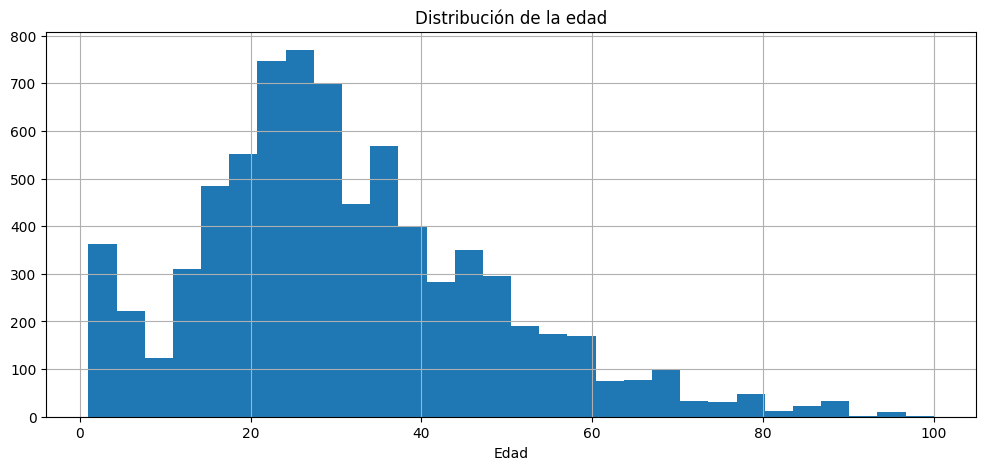

In [5]:
# Gráfica de la distribución de edad
plt.figure(figsize=(12,5))
labels['real_age'].hist(bins=30)
plt.title('Distribución de la edad')
plt.xlabel('Edad')
plt.show()

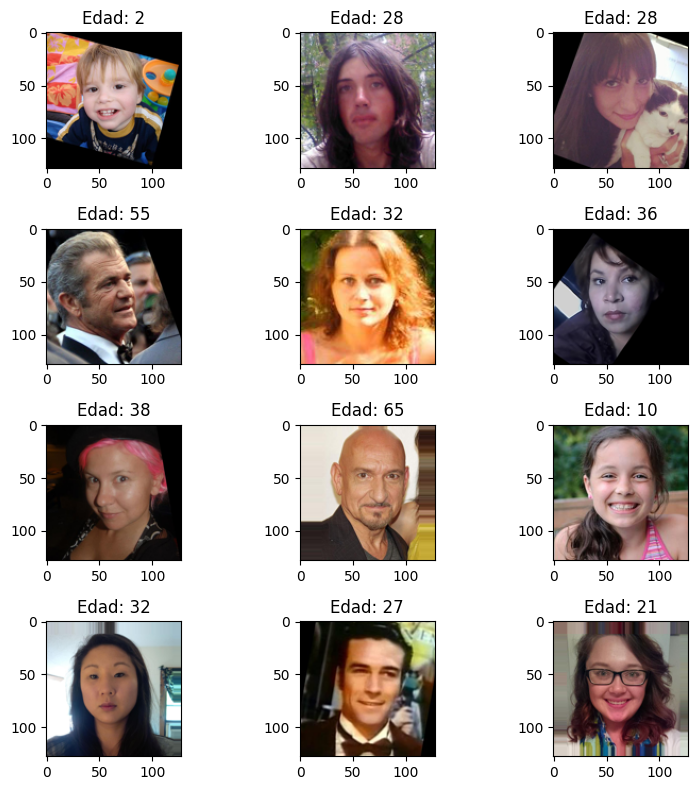

In [6]:
# Impresión de 12 imágenes aleatorias
samples = labels.sample(12, random_state=1234).reset_index(drop=True)
fig, axes = plt.subplots(4,3, figsize=(8,8))

for i, row in samples.iterrows():
    r = i//3; c = i%3
    img = Image.open(row['filepath']).convert("RGB").resize((128,128))
    axes[r,c].imshow(img)
    axes[r,c].set_title(f"Edad: {row['real_age']}")
    
plt.tight_layout()
plt.show()

### Conclusiones

A partir del análisis de la distibución de la edad, se observa lo siguiente:
- En su mayoría, las edades están distribuidas entre 20 y 30 años.
- Se confirma con el gráfico la media de 31 años y la mediana de 29 años.
- Se tiene una distribución sesgada hacia un rango etario joven, contando con menos datos para personas mayores de 50 años y niños pequeños.
- El modelo, a causa del sesgo, será mejor para predecir la edad de personas entre 20 y 40 años, y podría tener un mal rendimiento al predecir la edad de niños y adultos mayores.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [8]:
def load_train(path, image_size=(224,224), batch_size=32):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    
    Args:
        path: dirección de las imágenes
        img_size: tamaño target (alto, ancho)
        batch_size: tamaño de batch
        
    Returns:
        train_gen_flow: generador de entrenamiento
    """
    
    train_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale= 1/255,
                                  horizontal_fip=True,
                                  vertical_flip=True,
                                  rotation_range=90, 
                                  width_shift_range=0.20,
                                  height_shift_range=0.20)
    
    train_gen_flow = train_datagen.flow_from_directory(images_path,
                                                       x_col= 'file_path',
                                                       y_col= 'real_age',
                                                       target_size= image_size,
                                                       batch_size= batch_size,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345
                                                      )

    return train_gen_flow

In [9]:
def load_test(path, image_size=(224,224), batch_size=32):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    
    Args:
        path: dirección de las imágenes
        img_size: tamaño target (alto, ancho)
        batch_size: tamaño de batch
        
    Returns:
        train_gen_flow: generador de testeo
    """
    
    test_datagen = ImageDataGenerator(validation_split=0.2,
                                     rescale=1/255)
    
    test_gen_flow = test_datagen.flow_from_directory(images_path,
                                                       x_col= 'file_path',
                                                       y_col= 'real_age',
                                                       target_size= image_size,
                                                       batch_size= batch_size,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345
                                                    )

    return test_gen_flow

In [10]:
def create_model(input_shape):
    
    """
    Define una CNN ResNet50
    """
    
    backbone = ResNet50(input_shape = input_shape,
                       weights = 'imagenet',
                       include_top = False)
    
    backbone.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
    ]
    
    history= model.fit(train_data,
             validation_data= test_data,
             epochs=epochs,
             callbacks=cb,
             steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps,
             verbose=1)

    return model, history

In [13]:
# Funcion para graficar MAE a través de las epocas
def plot_history(history):
    hist = history.history
    plt.figure()
    plt.plot(hist['loss'], label='loss')
    if 'val_loss' in hist: plt.plot(hist['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Entrenamiento (MAE)')
    plt.legend()
    plt.show()

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [12]:
# prepara un script para ejecutarlo en la plataforma GPU

import inspect

init_str = """import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
"""

with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write("\n\n")
    for fn in [load_train, load_test, create_model, train_model, plot_history]:
        src = inspect.getsource(fn)
        f.write(src)
        f.write("\n\n")
    # main block: ajusta parámetros (epochs, batch_size) si quieres
    main_block = """
if __name__ == "__main__":
    labels_path = '/content/datasets/faces/faces/labels.csv'
    images_dir = '/content/datasets/faces/faces/final_files'

    train_gen = load_train(images_dir, labels_path, image_size=(224,224), batch_size=32)
    test_gen = load_test(images_dir, labels_path, image_size=(224,224), batch_size=32)

    model = create_model((224,224,3))
    model, history = train_model(model, train_gen, test_gen, epochs=20, steps_per_epoch=len(train_gen), validation_steps=len(test_gen))
    model.summary()
    plot_history(history)

    # Guardar modelo en Drive (asegúrate de que Drive esté montado desde el notebook)
    out_path = "/content/drive/MyDrive/age_prediction_model.h5"
    model.save(out_path)
    print("Modelo guardado en:", out_path)
"""
    f.write(main_block)

print("Script run_model_on_gpu.py creado.")

Script run_model_on_gpu.py creado.


### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - loss: 31.1134 - mae: 31.1134
Epoch 1: val_loss improved from inf to 28.15534, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 125s 590ms/step - loss: 31.1087 - mae: 31.1087 - val_loss: 28.1553 - val_mae: 28.1553 - learning_rate: 1.0000e-04
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - loss: 27.4724 - mae: 27.4724
Epoch 2: val_loss improved from 28.15534 to 24.51170, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 102s 535ms/step - loss: 27.4666 - mae: 27.4666 - val_loss: 24.5117 - val_mae: 24.5117 - learning_rate: 1.0000e-04
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 23.8259 - mae: 23.8259
Epoch 3: val_loss improved from 24.51170 to 21.14618, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 104s 548ms/step - loss: 23.8211 - mae: 23.8211 - val_loss: 21.1462 - val_mae: 21.1462 - learning_rate: 1.0000e-04
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 20.3719 - mae: 20.3719
Epoch 4: val_loss improved from 21.14618 to 18.21987, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 103s 540ms/step - loss: 20.3687 - mae: 20.3687 - val_loss: 18.2199 - val_mae: 18.2199 - learning_rate: 1.0000e-04
Epoch 5/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - loss: 17.5903 - mae: 17.5903
Epoch 5: val_loss improved from 18.21987 to 16.07455, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 103s 542ms/step - loss: 17.5884 - mae: 17.5884 - val_loss: 16.0745 - val_mae: 16.0745 - learning_rate: 1.0000e-04
Epoch 6/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - loss: 15.9163 - mae: 15.9163
Epoch 6: val_loss improved from 16.07455 to 14.68657, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 103s 542ms/step - loss: 15.9142 - mae: 15.9142 - val_loss: 14.6866 - val_mae: 14.6866 - learning_rate: 1.0000e-04
Epoch 7/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 14.7803 - mae: 14.7803
Epoch 7: val_loss improved from 14.68657 to 13.85304, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 543ms/step - loss: 14.7785 - mae: 14.7785 - val_loss: 13.8530 - val_mae: 13.8530 - learning_rate: 1.0000e-04
Epoch 8/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 14.0003 - mae: 14.0003
Epoch 8: val_loss improved from 13.85304 to 13.39990, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 104s 546ms/step - loss: 13.9992 - mae: 13.9992 - val_loss: 13.3999 - val_mae: 13.3999 - learning_rate: 1.0000e-04
Epoch 9/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 13.3284 - mae: 13.3284
Epoch 9: val_loss improved from 13.39990 to 13.20267, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 103s 543ms/step - loss: 13.3293 - mae: 13.3293 - val_loss: 13.2027 - val_mae: 13.2027 - learning_rate: 1.0000e-04
Epoch 10/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 13.3667 - mae: 13.3667
Epoch 10: val_loss improved from 13.20267 to 13.12377, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 101s 532ms/step - loss: 13.3667 - mae: 13.3667 - val_loss: 13.1238 - val_mae: 13.1238 - learning_rate: 1.0000e-04
Epoch 11/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 13.3999 - mae: 13.3999
Epoch 11: val_loss improved from 13.12377 to 13.09771, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 102s 537ms/step - loss: 13.3993 - mae: 13.3993 - val_loss: 13.0977 - val_mae: 13.0977 - learning_rate: 1.0000e-04
Epoch 12/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 13.1566 - mae: 13.1566
Epoch 12: val_loss improved from 13.09771 to 13.09183, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 539ms/step - loss: 13.1571 - mae: 13.1571 - val_loss: 13.0918 - val_mae: 13.0918 - learning_rate: 1.0000e-04
Epoch 13/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - loss: 13.0087 - mae: 13.0087
Epoch 13: val_loss did not improve from 13.09183
190/190 ━━━━━━━━━━━━━━━━━━━━ 100s 525ms/step - loss: 13.0098 - mae: 13.0098 - val_loss: 13.0925 - val_mae: 13.0925 - learning_rate: 1.0000e-04
Epoch 14/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 13.3111 - mae: 13.3111
Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 14: val_loss did not improve from 13.09183
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 523ms/step - loss: 13.3110 - mae: 13.3110 - val_loss: 13.0923 - val_mae: 13.0923 - learning_rate: 1.0000e-04
Epoch 15/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 13.3384 - mae: 13.3384
Epoch 15: val_loss did not improve from 13.09183
190/190 ━━━━━━━━━━━━━━━━━━━━ 144s 537ms/step - loss: 13.3380 - mae: 13.3380 - val_loss: 13.0929 - val_mae: 13.0929 - learning_rate: 5.0000e-05
Epoch 16/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - loss: 13.0706 - mae: 13.0706
Epoch 16: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 16: val_loss did not improve from 13.09183
190/190 ━━━━━━━━━━━━━━━━━━━━ 137s 513ms/step - loss: 13.0715 - mae: 13.0715 - val_loss: 13.0929 - val_mae: 13.0929 - learning_rate: 5.0000e-05
Epoch 17/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 13.3170 - mae: 13.3170
Epoch 17: val_loss did not improve from 13.09183
190/190 ━━━━━━━━━━━━━━━━━━━━ 100s 526ms/step - loss: 13.3168 - mae: 13.3168 - val_loss: 13.0932 - val_mae: 13.0932 - learning_rate: 2.5000e-05

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 23,593,861 (90.00 MB)
 Trainable params: 2,049 (8.00 KB)
 Non-trainable params: 23,587,712 (89.98 MB)
 Optimizer params: 4,100 (16.02 KB)

## Conclusiones

- El modelo no presenta sobreajuste, no existe gran diferencia entre la pérdida de entrenamiento y validación.
- Hasta la epoca 12 se observa una disminución constante de la métrica loss y mae.
- A partir de la época 13 se ve un estancamiento en la mejora del modelo, a pesar de cambiar la tasa de aprendizaje.
- El mejor MAE se guardó en la época 12, alcanzando un valor de 13.09.